No artifacts
Spectrograms
Time coherence?
3 subjects, should be split?

In [12]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
from biosppy_custom.signals import eeg, emg, tools

In [3]:
import multiprocessing

def multiproc(df, func, n_jobs = None):
    if n_jobs is None:
        n_jobs = multiprocessing.cpu_count()
    num_partitions = n_jobs
    print('Parallelizing into',num_partitions,'batches.')
    df_split = np.array_split(df, num_partitions)
    pool = multiprocessing.Pool(n_jobs)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def prnt_prog(i,n):
    return not i%(n//50) and print("%03d%%"%(i//(n//50)*2), end='\r',flush=True)

# func has to return a dict of features to add to the row
def apply_row_wise(df, func, prefix=''):
    n = len(df)
    rets = [prnt_prog(i,n) or func(row[1]) for i, row in enumerate(df.iterrows())]
    for field in rets[0].keys():
        df[prefix+field] = [r[field] for r in rets]
    return df

In [4]:
import csv
# returns a dict mapping sample id [int] to the raw time series [np.array]
def importTimeSeries(filename):
    datafile = open(filename, 'r')
    datareader = csv.reader(datafile)
    out = dict()
    first = True
    for row in datareader:
        if first:
            first = False
            continue
        out[int(row[0])] = np.asarray(row[1:], dtype=float)
    return out

In [424]:
train_eeg1 = importTimeSeries('test_eeg1.csv')
print('Done: train_eeg1', end='')
train_eeg2 = importTimeSeries('test_eeg2.csv')
print(', train_eeg2', end='')
train_emg  = importTimeSeries('test_emg.csv')
print(', train_emg', end='')
train = pd.read_csv('sample.csv').set_index('Id',drop=False)
train['eeg1'] = [train_eeg1[k] for k in train.index.values]
train['eeg2'] = [train_eeg2[k] for k in train.index.values]
train['emg']  = [train_emg [k] for k in train.index.values]
print(' ,train_labels.')
print('Merged into Dataframe: train')

Done: train_eeg1, train_eeg2, train_emg ,train_labels.
Merged into Dataframe: train


In [425]:
del train_eeg1
del train_eeg2
del train_emg

In [426]:
train['individual'] = [id//(len(train)/2) for id in train.Id]

In [427]:
def apply_biosppy_eeg(df): 
    def func(row):
        return eeg.eeg(signal=np.array([row.eeg1,row.eeg2]).transpose(),
                       sampling_rate=128, show=False)
    return apply_row_wise(df, func, 'eeg_')
train = multiproc(train, apply_biosppy_eeg)

Parallelizing into 72 batches.


In [428]:
def apply_biosppy_emg(df): 
    def func(row):
        return emg.emg(signal=np.array(row.emg),
                       sampling_rate=128, show=False, freq=60)
    return apply_row_wise(df, func, 'emg_')
train = multiproc(train, apply_biosppy_emg)

Parallelizing into 72 batches.


In [429]:
sig_names =  ['eeg_theta',
              'eeg_alpha_low',
              'eeg_alpha_high',
              'eeg_beta',
              'eeg_gamma',
              'eeg_plf',
              'emg'
             ]
stats = {'mean':np.mean, 
         'median':np.median, 
         'min':np.min, 
         'max':np.max, 
         'std':np.std,
         'rms':lambda x,axis:np.sqrt(np.mean(x**2))
        }

def stats_on_signals(df):
    def func(row):
        return {(sig_name+'_'+stat_name):np.median(f(row[sig_name],axis=0))
                for sig_name in sig_names
                for (stat_name,f) in stats.items()
               }
    return apply_row_wise(df, func, '')

train = multiproc(train, stats_on_signals, n_jobs=16)

Parallelizing into 16 batches.


In [430]:
sig_names =  ['emg_onsets'
             ]
stats = {'mean':np.mean, 
         'median':np.median, 
         'min':np.min, 
         'max':np.max, 
         'std':np.std,
         'cnt':len,
        }

def stats_on_signals(df):
    def func(row):
        return {(sig_name+'_'+stat_name):(0 if len(row[sig_name])==0 else np.median(f(row[sig_name])))
                for sig_name in sig_names
                for (stat_name,f) in stats.items()
               }
    return apply_row_wise(df, func, '')

train = multiproc(train, stats_on_signals, n_jobs=16)

Parallelizing into 16 batches.


# Preprocessing

In [359]:
scalar_feats = []
for feat in train.columns:
    if feat == 'Id' or feat == 'y' or feat == 'individual': continue
    if np.isscalar(train[feat][0]): scalar_feats.append(feat)

In [360]:
def recursive_correlation_pruning(myfeats, df, max_corr=.8):
    tmp_feats = myfeats.copy()
    while True:
        ntf = len(tmp_feats)
        X_temp = df[tmp_feats].values
        corrcoef = np.corrcoef(X_temp.transpose())
        sort1d = np.argsort(-abs(corrcoef), axis=None)
        pairs = np.array([sort1d//ntf,sort1d%ntf]) # 2 rows, n^2 columns
        uniquepairs = pairs[:,pairs[0,:]>pairs[1,:]].transpose()
        mypair = uniquepairs[0]
        cc = corrcoef[mypair[0],mypair[1]]
        print("{:<1} {:<23} {: <23} {: <20}".format(ntf,tmp_feats[mypair[0]],tmp_feats[mypair[1]],
                  cc), end='')
        if abs(cc) > max_corr:
            leaving = tmp_feats[mypair[1]]

            #print('\t',mypair,end='') 
            print('\tremoving ',leaving)
            tmp_feats.remove(leaving)
        else: 
            print('\tstopping')
            return tmp_feats
            
rcp = recursive_correlation_pruning

In [361]:
myfeats = rcp(scalar_feats,train)

48 emg_rms                 emg_std                 0.9996217273841128  	removing  emg_std
47 eeg_beta_rms            eeg_beta_mean           0.9881115838135553  	removing  eeg_beta_mean
46 emg_onsets_median       emg_onsets_mean         0.9864574878259154  	removing  emg_onsets_mean
45 eeg_alpha_high_rms      eeg_alpha_high_mean     0.9853941627286301  	removing  eeg_alpha_high_mean
44 eeg_alpha_low_rms       eeg_alpha_low_mean      0.9853572184701411  	removing  eeg_alpha_low_mean
43 eeg_theta_rms           eeg_theta_mean          0.9850256542500013  	removing  eeg_theta_mean
42 eeg_gamma_rms           eeg_gamma_mean          0.9805778743936878  	removing  eeg_gamma_mean
41 eeg_plf_rms             eeg_plf_mean            0.979865016148036   	removing  eeg_plf_mean
40 eeg_alpha_high_std      eeg_alpha_high_max      0.9743152865363852  	removing  eeg_alpha_high_max
39 eeg_beta_std            eeg_beta_max            0.9726224591065727  	removing  eeg_beta_max
38 eeg_theta_std           e

In [431]:
print('kept:')
for feat in myfeats:
    print(feat)

kept:
eeg_theta_min
eeg_alpha_low_min
eeg_alpha_high_min
eeg_beta_min
eeg_gamma_min
eeg_plf_median
eeg_plf_max
eeg_plf_std
emg_mean
emg_median
emg_onsets_min
emg_onsets_max
emg_onsets_std
emg_onsets_cnt
eeg_theta_rms
eeg_alpha_high_rms
eeg_beta_rms
eeg_gamma_rms
eeg_plf_rms
emg_rms


In [432]:
X_raw = train[myfeats].values
y_raw = train['y']
print(np.shape(X_raw))
n_train = len(y_raw)

(43200, 20)


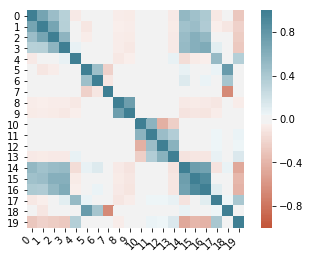

In [433]:
import my_utils
corrcoef = np.corrcoef(X_raw.transpose())
np.shape(corrcoef)
my_utils.corrmap(corrcoef)

In [434]:
# throw some time correlation into the pot: use previous and following features
padding = [np.zeros(np.shape(X_raw)[1])]
X_prev = np.concatenate([ padding,     X_raw[:-1,:] ])
X_prev2 = np.concatenate([ padding,     X_prev[:-1,:] ])
X_prev3 = np.concatenate([ padding,     X_prev[:-1,:] ])
X_foll = np.concatenate([ X_raw[1:,:], padding      ])
X_foll2 = np.concatenate([ X_foll[1:,:], padding      ])
X_foll3 = np.concatenate([ X_foll[1:,:], padding      ])

X_coh = np.concatenate([
                        X_prev2, 
                        X_prev, 
                        X_raw, 
                        X_foll, 
                        X_foll2
                       ], axis=1)
np.shape(X_coh)

(43200, 100)

In [ ]:
extfeats = []
extfeats += [feat+"-2" for feat in myfeats]
extfeats += [feat+"-1" for feat in myfeats]
extfeats += myfeats
extfeats += [feat+"+1" for feat in myfeats]
extfeats += [feat+"+2" for feat in myfeats]

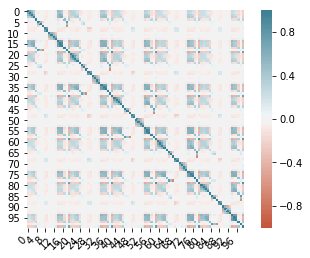

In [435]:
my_utils.corrmap(np.corrcoef(X_coh.transpose()))

In [413]:
# Normalize because small valued features seem to be ignored by RF. IS THIS A BUG IN SKLEARN!?
#from sklearn.preprocessing import scale
#X_sc = scale(X_coh)

In [436]:
# Normalize to eliminate variance between individuals
from sklearn.preprocessing import scale
X_sc1 = scale(X_coh[              0 :   len(train)//2,:])
#X_sc2 = scale(X_coh[  len(train)//3 : 2*len(train)//3,:])
X_sc3 = scale(X_coh[len(train)//2 :                ,:])
X_sc = np.concatenate([X_sc1, 
                       #X_sc2, 
                       X_sc3])
del X_sc1, X_sc3

In [415]:
counts = {i:np.sum(y_raw == i) for i in np.unique(y_raw)}
weights = {i:float(n_train)/(np.sum(y_raw == i)) for i in np.unique(y_raw)}

print(counts)
print(weights)
weights[3]*=10

{1: 34114, 2: 27133, 3: 3553}
{1: 1.8995133962596003, 2: 2.3882357277116428, 3: 18.23810864058542}


In [416]:
X_ready = X_sc

In [421]:
from sklearn.model_selection import train_test_split 
X_tr, X_te, y_tr, y_te = train_test_split(X_ready, y_raw, 
                                          random_state=667,
                                          test_size=.01, 
                                          #test_size=0.25,
                                         )
n_te = len(y_te)
n_tr = len(y_tr)
print('full :',["%.2f"%(np.mean(y_raw == cl)) for cl in np.unique(y_raw)])
print('train:',["%.2f"%(np.mean(y_tr == cl))  for cl in np.unique(y_tr)])
print('test :',["%.2f"%(np.mean(y_te == cl))  for cl in np.unique(y_te)])
np.shape(X_tr)

full : ['0.53', '0.42', '0.05']
train: ['0.53', '0.42', '0.05']
test : ['0.55', '0.40', '0.05']


(64152, 100)

# Try fitting one of my beloved Random Forests

In [422]:
import gc
gc.collect()

6640

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


Detailed classification report:
              precision    recall  f1-score   support

           1       0.99      0.95      0.97 678.1262824646782
           2       0.49      0.90      0.64 618.5530534773119
           3       0.99      0.91      0.95 5836.194764987334

    accuracy                           0.91 7132.8741009293235
   macro avg       0.82      0.92      0.85 7132.8741009293235
weighted avg       0.95      0.91      0.92 7132.8741009293235


Normalized confusion matrix
[[ 0.94677871  0.04761905  0.00560224]
 [ 0.01544402  0.9034749   0.08108108]
 [ 0.          0.09375     0.90625   ]]

What matters:
test  bmac = 0.91883453832 	train bmac = 0.962437426266


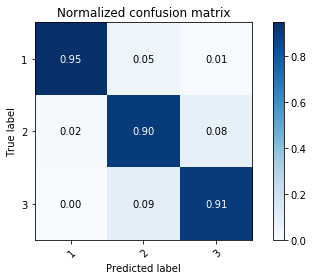

In [423]:
rf = RandomForestClassifier(n_estimators=500,
                            max_depth=None,
                            min_samples_split=10,
                            min_samples_leaf=30,
                            n_jobs=-1, 
                            class_weight=weights,
                            max_features=None,
                            verbose=1)
rf.fit(X_tr, y_tr)

pred_te  = rf.predict(X_te)
pred_tr = rf.predict(X_tr)

print("Detailed classification report:")
samwe = [weights[int(yi)] for yi in y_te]
print(classification_report(y_te, pred_te, sample_weight = samwe))
print()

plot_confusion_matrix(y_te, pred_te, np.array([0,1,2,3]),normalize=True, )
print()
print('What matters:')
print('test  bmac =',   bmac(y_te, pred_te),
      '\ttrain bmac =', bmac(y_tr, pred_tr))



In [437]:
np.shape(X_sc)

(43200, 100)

In [438]:
pred = rf.predict(X_sc)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.3s finished


In [440]:
from datetime import datetime
def prepare_submission(y_graded, comment = ""):
    y_out_template = np.genfromtxt ('sample.csv', delimiter=",")[1:]
    filename = datetime.now().strftime("%m.%d.%H.%M")+"_"+comment+".csv"
    print(filename)
    y_out=y_out_template
    y_out[:,1] = y_graded
    np.savetxt(filename, y_out, delimiter=",",header="Id,y", fmt='%d',  comments='')
prepare_submission(pred, 'seb')

12.22.01.35_seb.csv


In [303]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'n_estimators': [400], 
                     'max_depth': [None], 
                   # 'criterion': ['gini',],
                     'min_samples_split': [3,10,30], 
                     'min_samples_leaf': [3,10,30], 
                   # 'min_weight_fraction_leaf': [0], 
                     'max_features': [None], 
                   # 'max_leaf_nodes': [None],#,100, 300, 500], 
                   # 'min_impurity_decrease': [0], 
                   # 'bootstrap': [True], 
                   # 'oob_score': [False,], 
                   # 'class_weight': [weights]
                    },
                   ]
#scorer = make_scorer(f1_score, average = 'micro')

clf = GridSearchCV(RandomForestClassifier(
                                          n_jobs=-1,
                                          class_weight=weights,
                                         ),
                   tuned_parameters, 
                   cv     =5,
                   scoring='balanced_accuracy',
                   n_jobs =-1, 
                   verbose=10,
                   )

clf.fit(X_tr, y_tr)
print('done')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  45 | elapsed: 15.7min remaining: 220.4min
[Parallel(n_jobs=-1)]: Done   8 out of  45 | elapsed: 15.9min remaining: 73.4min
[Parallel(n_jobs=-1)]: Done  13 out of  45 | elapsed: 16.2min remaining: 40.0min
[Parallel(n_jobs=-1)]: Done  18 out of  45 | elapsed: 16.9min remaining: 25.4min
[Parallel(n_jobs=-1)]: Done  23 out of  45 | elapsed: 17.0min remaining: 16.3min
[Parallel(n_jobs=-1)]: Done  28 out of  45 | elapsed: 17.1min remaining: 10.4min
[Parallel(n_jobs=-1)]: Done  33 out of  45 | elapsed: 17.1min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed: 17.1min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed: 17.2min remaining:   47.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 17.2min finished


done


In [318]:
import gc
gc.collect()

20599

In [320]:
pred_te  = clf.predict(X_te)
pred_tr = clf.predict(X_tr)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 400 out of 400 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 400 out of 400 | elapsed:    0.2s finished


In [321]:
from my_utils import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score as bmac
from sklearn.metrics import classification_report 

print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Best parameters set found on development set:")
print(clf.best_params_)
print()

print("Detailed classification report:")
samwe = [weights[int(yi)] for yi in y_te]
print(classification_report(y_te, pred_te, sample_weight = samwe))
print()

plot_confusion_matrix(y_te, pred_te, np.array([0,1,2,3]),normalize=True, )
print()
print('What matters:')
print('test  bmac =',   bmac(y_te, pred_te),
      '\ttrain bmac =', bmac(y_tr, pred_tr))



Grid scores on development set:



AttributeError: 'RandomForestClassifier' object has no attribute 'cv_results_'

In [310]:
forest = clf.best_estimator_
forest.n_features_

60

Feature ranking:
#1: emg_rms	importance=0.491483	std=0.004873	<-- low variance
#2: eeg_beta_rms+1	importance=0.161332	std=0.068908	<-- low variance
#3: eeg_beta_rms	importance=0.089342	std=0.075477	<-- low variance
#4: eeg_beta_rms-1	importance=0.045117	std=0.013535	<-- low variance
#5: eeg_alpha_low_min+1	importance=0.027837	std=0.009870	<-- low variance
#6: emg_rms-1	importance=0.023167	std=0.009396	<-- low variance
#7: eeg_theta_rms	importance=0.022292	std=0.005625	<-- low variance
#8: eeg_theta_min	importance=0.018442	std=0.017222	<-- low variance
#9: eeg_alpha_low_min	importance=0.017101	std=0.012778	<-- low variance
#10: eeg_alpha_low_min-1	importance=0.015145	std=0.007559	<-- low variance
#11: eeg_theta_rms-1	importance=0.013762	std=0.011801	<-- low variance
#12: eeg_theta_min-1	importance=0.012965	std=0.008774	<-- low variance
#13: eeg_alpha_high_rms+1	importance=0.008667	std=0.005799	<-- low variance
#14: eeg_theta_rms+1	importance=0.005849	std=0.003680	<-- low variance
#15: e

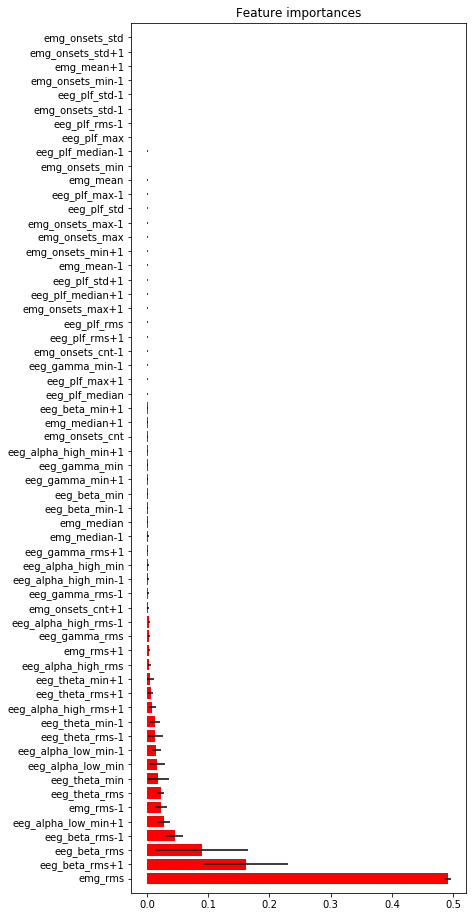

In [311]:
forest = clf.best_estimator_
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
nfeats = len(indices)
# Print the feature ranking
print("Feature ranking:")
# myfeats is the list of column names we used
pos = 0
for i in indices:
    pos+=1
    print("#%d: %s\timportance=%f\tstd=%f" % 
          (pos, extfeats[i], importances[i],std[i]), 
          end = '')
    if  importances[i] > std[i]:
        print('\t<-- low variance')
    else: print()

# Plot the feature importances of the forest
plt.figure(figsize=(6,16))
plt.title("Feature importances")
plt.barh(range(nfeats), importances[indices],
       color="r", xerr=std[indices], align="center")
plt.yticks(range(nfeats), [extfeats[i] for i in indices],rotation=0)
plt.ylim([-1,nfeats])
plt.show()

In [309]:
print('Done')

Done


In [357]:
#temporal coherence

In [358]:
pred_te  = clf.predict(X_te)
pred_tr = clf.predict(X_tr)

In [359]:
proba_te = clf.predict_proba(X_te)
proba_tr = clf.predict_proba(X_tr)

In [360]:
proba_te2 = np.array([ np.convolve(proba_te[:,i],[1,1],mode='same' ) for i in range(3)]).T / 2
proba_tr2 = np.array([ np.convolve(proba_tr[:,i],[1,1],mode='same' ) for i in range(3)]).T / 2

In [361]:
pred_te2 = np.argmax(proba_te2,axis=1)+1
pred_tr2 = np.argmax(proba_tr2,axis=1)+1

Detailed classification report:
              precision    recall  f1-score   support

           1       0.03      0.90      0.05 16206.648296888403
           2       0.04      0.49      0.07 16180.297055249252
           3       1.00      0.55      0.71 1628663.1016042894

    accuracy                           0.55 1661050.046956427
   macro avg       0.35      0.64      0.27 1661050.046956427
weighted avg       0.98      0.55      0.69 1661050.046956427


Normalized confusion matrix
[[ 0.9011955   0.07337084  0.02543366]
 [ 0.43158672  0.48693727  0.08147601]
 [ 0.32698768  0.12765957  0.54535274]]

What matters:
test  bmac = 0.644495170743 	train bmac = 0.659862732838


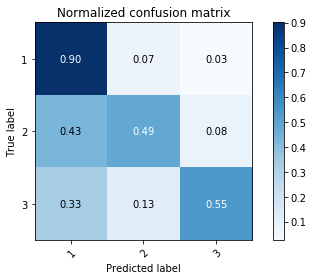

In [362]:
from my_utils import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score as bmac
from sklearn.metrics import classification_report 

print("Detailed classification report:")
samwe = [weights[int(yi)] for yi in y_te]
print(classification_report(y_te, pred_te2, sample_weight = samwe))
print()

plot_confusion_matrix(y_te, pred_te2, np.array([0,1,2,3]),normalize=True, )
print()
print('What matters:')
print('test  bmac =',   bmac(y_te, pred_te2),
      '\ttrain bmac =', bmac(y_tr, pred_tr2))

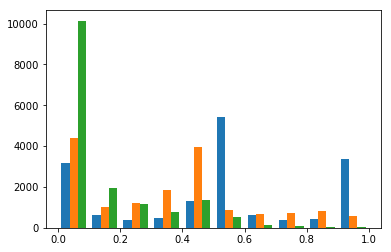

TypeError: hist() missing 1 required positional argument: 'x'

In [363]:
plt.hist(proba_te2)
plt.show()
plt.hist()
plt.show()

# Play around a bit

In [24]:
# USEFUL ANALYIS STUFF
def subsets():
    subs = [
        train[(train.y==y) & (train.individual==indiv)]
        for y in [1,2,3]
        for indiv in [0.,1.,2.]
    ]
    return subs

def randrow(i=-1):
    if i==-1:
        return train.sample(1).iloc[0]
    else:
        return subsets()[i].sample(1).iloc[0]
    
def box(field):
    plt.boxplot([sub[field] for sub in subsets()], whis=[5, 95])
    plt.show()

In [25]:
# ALTERANTIVE FOR ONLY CLASS 2 VS 3 
def subsets():
    subs = [
        train[train.y==y]
        for y in [2,3]
    ]
    return subs

def randrow(i=-1):
    if i==-1:
        return train.sample(1).iloc[0]
    else:
        return subsets()[i].sample(1).iloc[0]
    
def box(field):
    plt.boxplot([sub[field] for sub in subsets()], whis=[5, 95],showfliers=False)
    plt.show()

In [26]:
[(sub.iloc[0].individual,sub.iloc[0].y) for sub in subsets()]

[(-0.0, 2), (0.0, 3)]

Id


/cluster/apps/python/3.6.1/x86_64/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


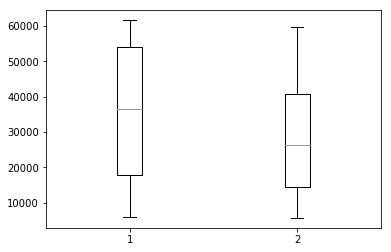

y


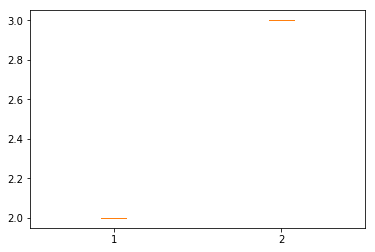

individual


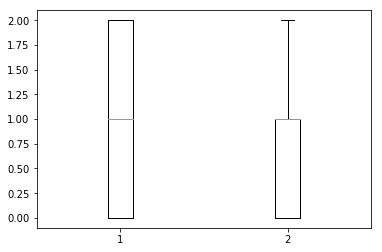

eeg_theta_mean


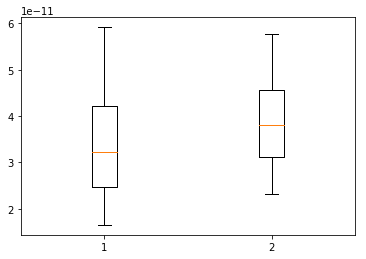

eeg_theta_median


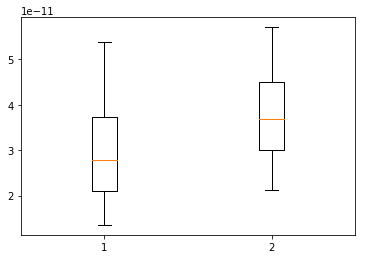

eeg_theta_min


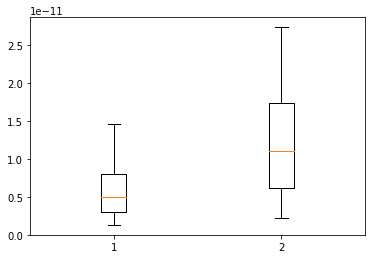

eeg_theta_max


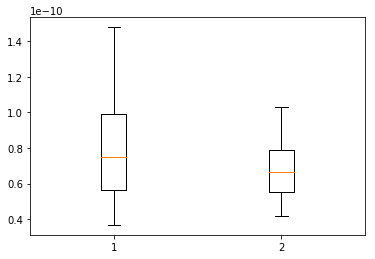

eeg_theta_std


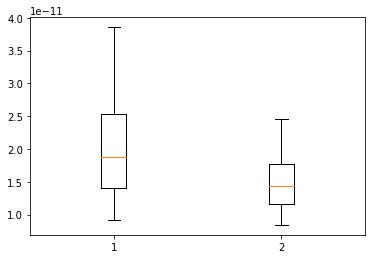

eeg_alpha_low_mean


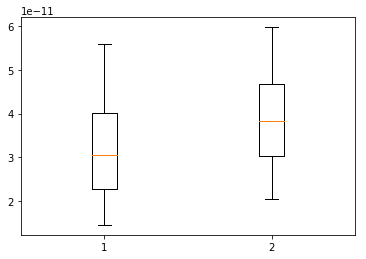

eeg_alpha_low_median


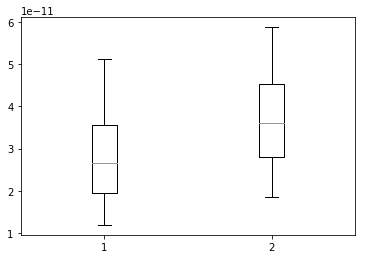

eeg_alpha_low_min


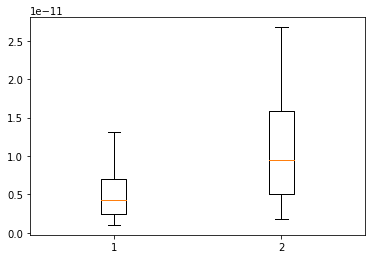

eeg_alpha_low_max


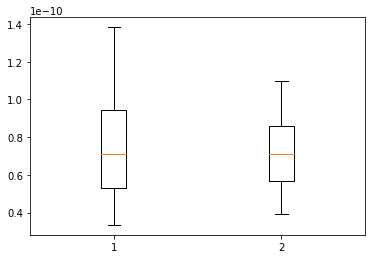

eeg_alpha_low_std


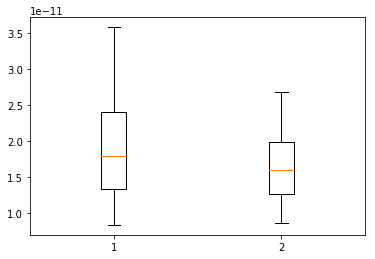

eeg_alpha_high_mean


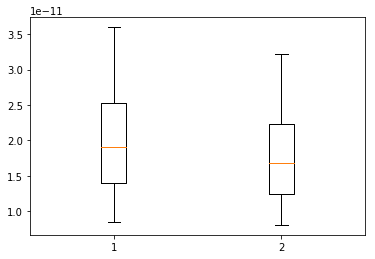

eeg_alpha_high_median


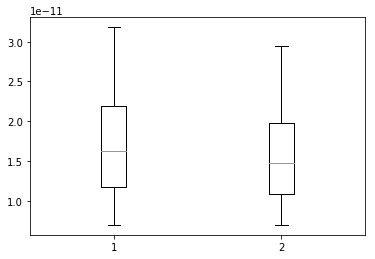

eeg_alpha_high_min


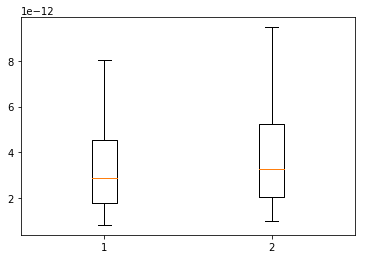

eeg_alpha_high_max


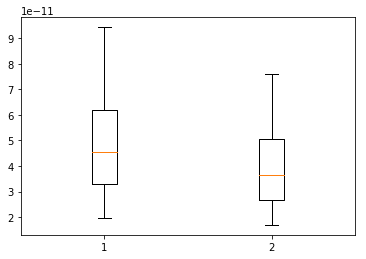

eeg_alpha_high_std


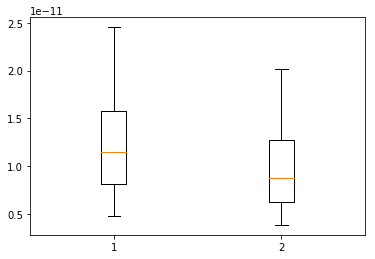

eeg_beta_mean


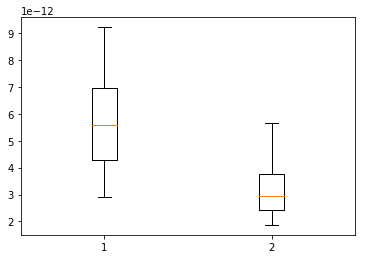

eeg_beta_median


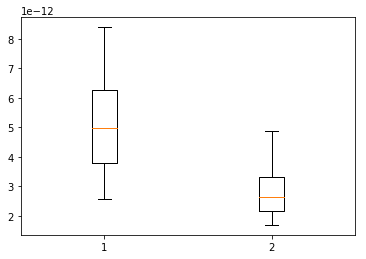

eeg_beta_min


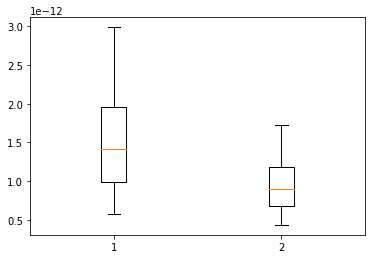

eeg_beta_max


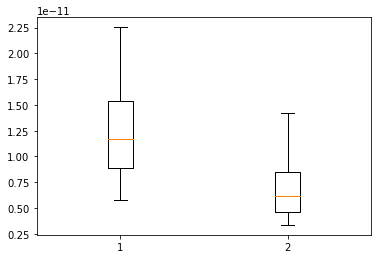

eeg_beta_std


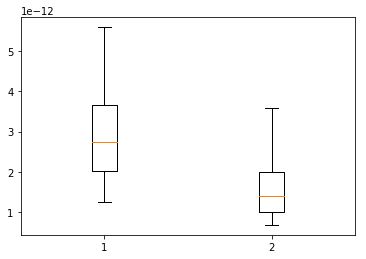

eeg_gamma_mean


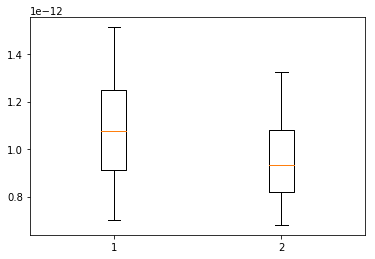

eeg_gamma_median


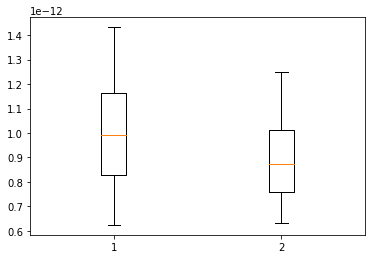

eeg_gamma_min


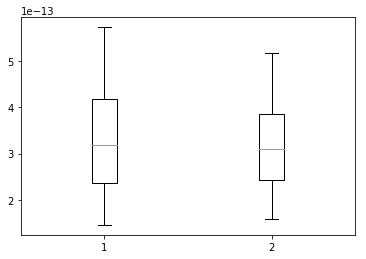

eeg_gamma_max


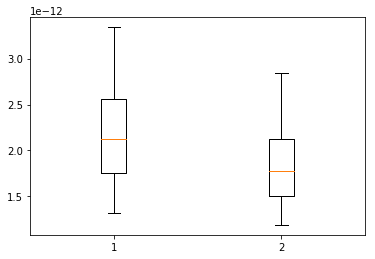

eeg_gamma_std


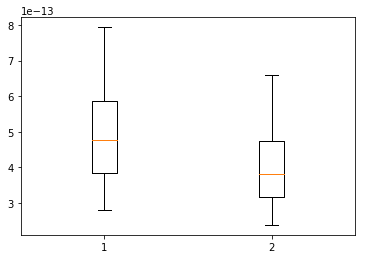

eeg_plf_mean


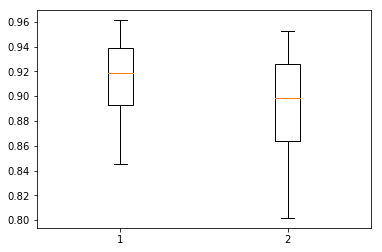

eeg_plf_median


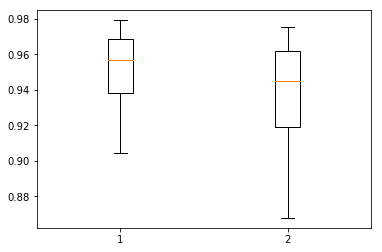

eeg_plf_min


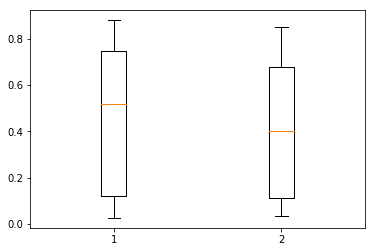

eeg_plf_max


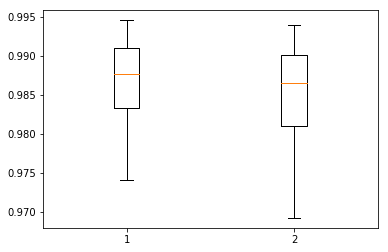

eeg_plf_std


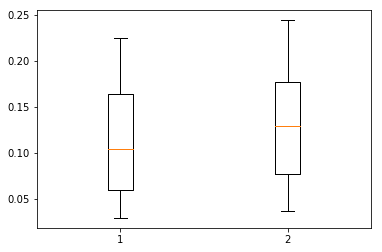

emg_mean


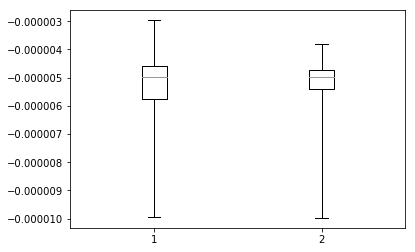

emg_median


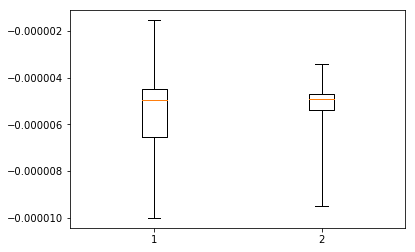

emg_min


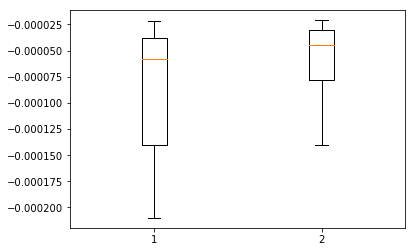

emg_max


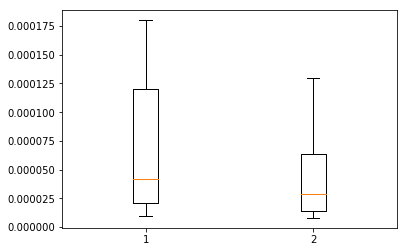

emg_std


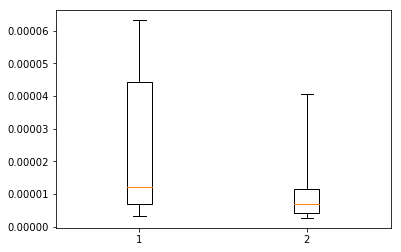

emg_onsets_mean


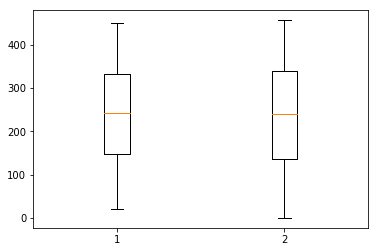

emg_onsets_median


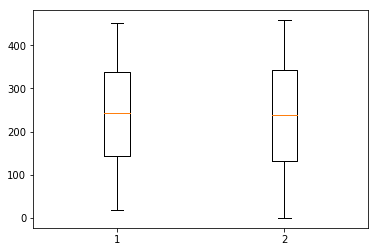

emg_onsets_min


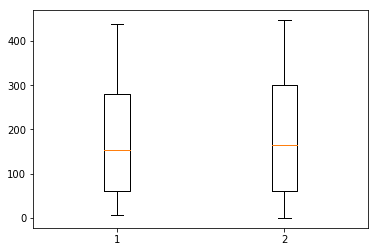

emg_onsets_max


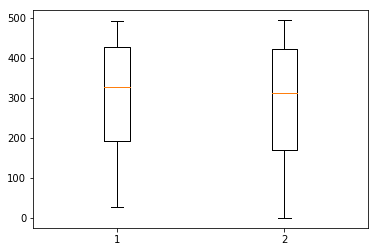

emg_onsets_std


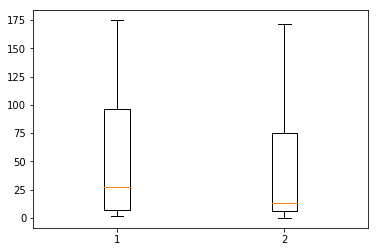

emg_onsets_cnt


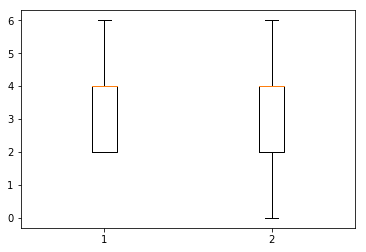

In [27]:
# grouped by class, split by individual
for feat in train.columns:
    if np.isscalar(train[feat][0]):
        print(feat)
        box(feat)

In [28]:
for col in train.columns:
    print('{:<15s} {:<20s}'.format(col, str(np.shape(train.iloc[0][col]))))

Id              ()                  
y               ()                  
eeg1            (512,)              
eeg2            (512,)              
emg             (512,)              
individual      ()                  
eeg_ts          (512,)              
eeg_filtered    (512, 2)            
eeg_features_ts (31,)               
eeg_theta       (31, 2)             
eeg_alpha_low   (31, 2)             
eeg_alpha_high  (31, 2)             
eeg_beta        (31, 2)             
eeg_gamma       (31, 2)             
eeg_plf_pairs   (1, 2)              
eeg_plf         (31, 1)             
emg_ts          (512,)              
emg_filtered    (512,)              
emg_onsets      (2,)                
eeg_theta_mean  ()                  
eeg_theta_median ()                  
eeg_theta_min   ()                  
eeg_theta_max   ()                  
eeg_theta_std   ()                  
eeg_alpha_low_mean ()                  
eeg_alpha_low_median ()                  
eeg_alpha_low_min ()         

In [45]:
train.iloc[0:36].y

Id
0     2
1     2
2     2
3     2
4     2
5     3
6     3
7     3
8     3
9     3
10    3
11    3
12    3
13    3
14    3
15    3
16    3
17    3
18    3
19    3
20    3
21    3
22    3
23    3
24    3
25    3
26    3
27    3
28    3
29    3
30    3
31    3
32    3
33    1
34    1
35    1
Name: y, dtype: int64

In [88]:
delta = np.concatenate([[1], np.diff(train.y.values==3),[1]])
durations = np.diff(np.where(np.abs(delta)==1)[0].reshape(-1, 2))
min(durations)

array([3])

In [31]:
def plotraw(sample):
    time = start + sample['eeg_ts'].values
    feat_time = [start[i] + sample.eeg_features_ts.values[i] for i in range(len(start))]
    np.shape(np.concatenate(time))
    plt.figure(figsize=(20, 20))
    nplots = str(8)
    ax=plt.subplot(nplots+'1'+str(1))
    ax.step(start+2, sample['y'], where='mid')
    ax.set_ylim([1,3])
    ax=plt.subplot(nplots+'1'+str(2),sharex=ax)
    ax.plot(np.concatenate(feat_time),
             np.concatenate(sample['eeg_theta'].values[:][:]))
    ax=plt.subplot(nplots+'1'+str(3),sharex=ax)
    ax.plot(np.concatenate(feat_time),
             np.concatenate(sample['eeg_alpha_low'].values[:][:]))
    ax=plt.subplot(nplots+'1'+str(4),sharex=ax)
    ax.plot(np.concatenate(feat_time),
             np.concatenate(sample['eeg_alpha_high'].values[:][:]))
    ax=plt.subplot(nplots+'1'+str(5),sharex=ax)
    ax.plot(np.concatenate(feat_time),
             np.concatenate(sample['eeg_beta'].values[:][:]))
    ax=plt.subplot(nplots+'1'+str(6),sharex=ax)
    ax.plot(np.concatenate(feat_time),
             np.concatenate(sample['eeg_gamma'].values[:][:]))
    ax=plt.subplot(nplots+'1'+str(7),sharex=ax)
    ax.plot(np.concatenate(time),
             np.concatenate(sample['emg'].values[:][:]))
    ax=plt.subplot(nplots+'1'+str(8),sharex=ax)
    ax.step(start+2,
             sample['emg_onsets_cnt'], where='mid')
    plt.show()

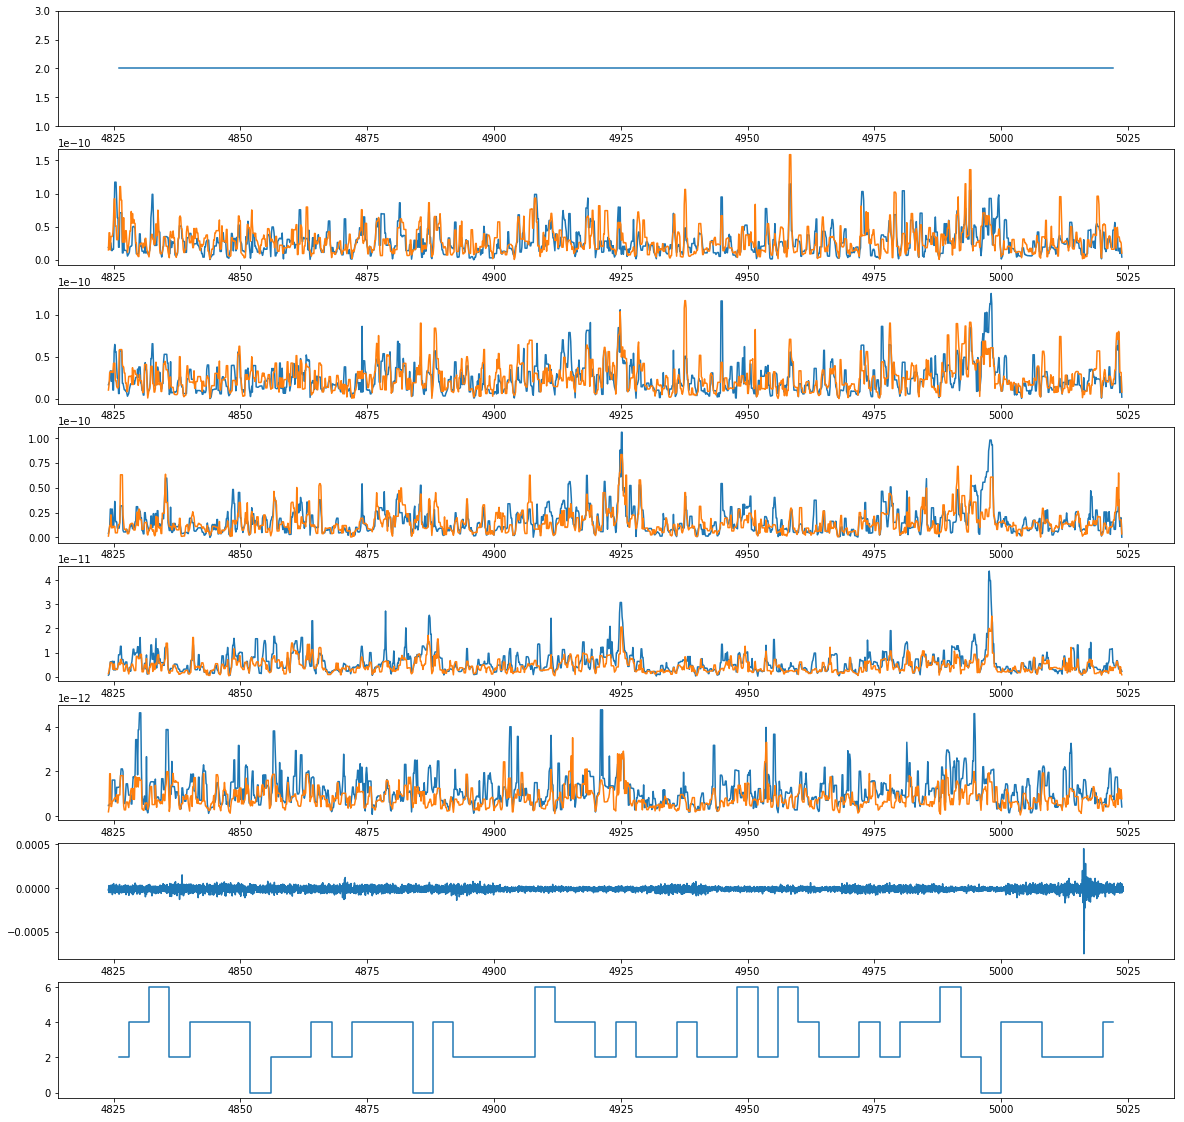

In [32]:
begin = 4825//4
finish = begin+50
start = np.array(range(begin,finish))*4
sample = train[train.y == 2].iloc[begin:finish]
plotraw(sample)

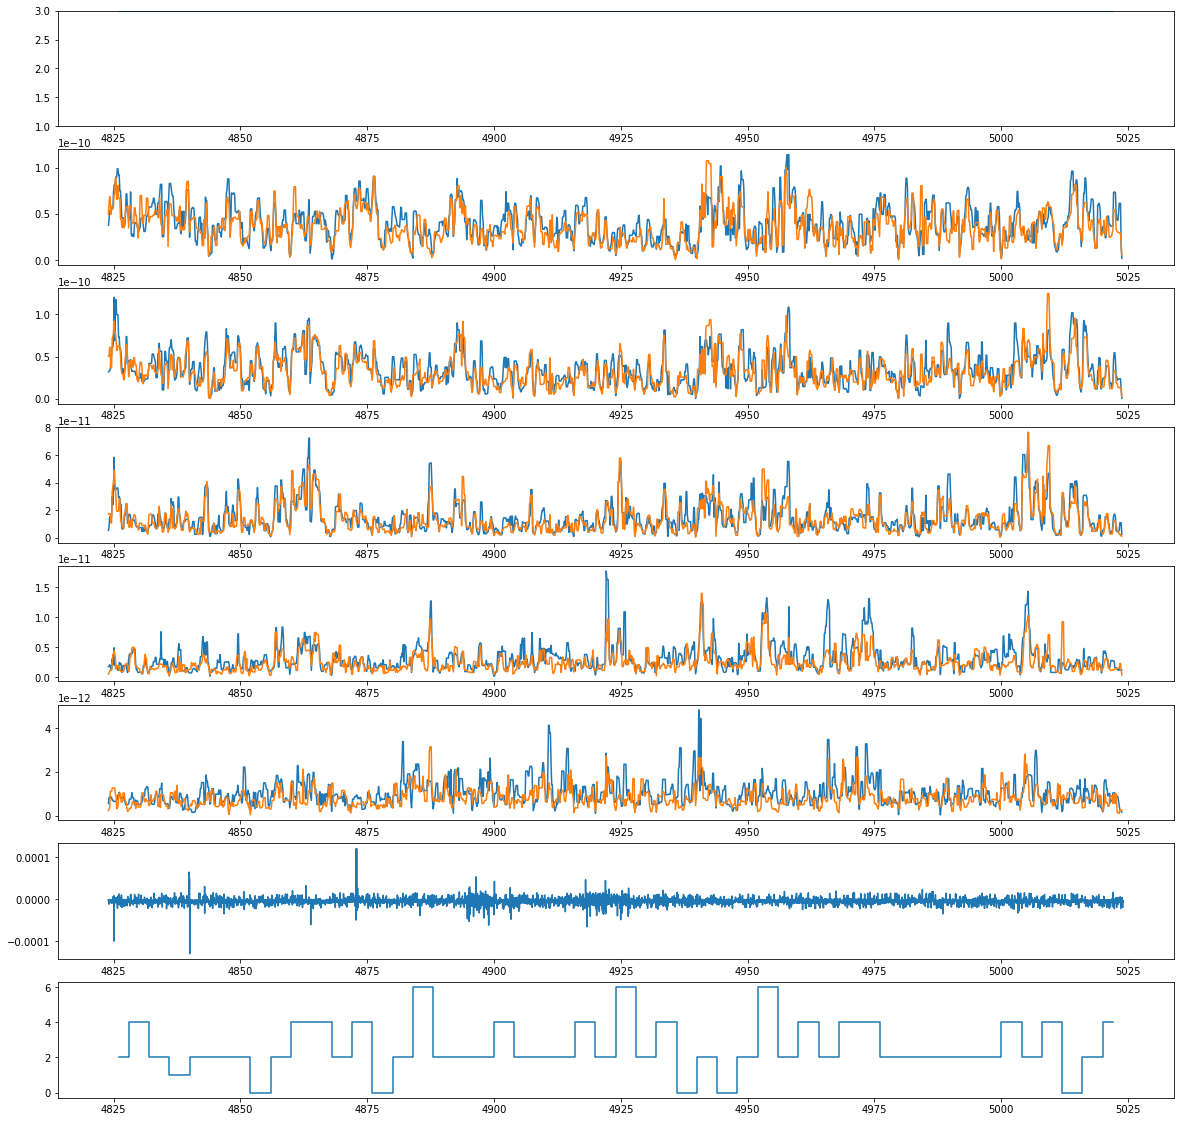

In [33]:
begin = 4825//4
finish = begin+50
start = np.array(range(begin,finish))*4
sample = train[train.y == 3].iloc[begin:finish]
plotraw(sample)

In [34]:
bef = train[np.append(delta,0)==1].iloc[0:3]
aft = train[np.append(0,delta)==1].iloc[0:3]
print(bef.y)
print('-------')
print(aft.y)

Id
4      2
296    1
300    1
Name: y, dtype: int64
-------
Id
5      3
297    2
301    2
Name: y, dtype: int64


In [35]:
feat = 'emg'
for databef, dataaft in zip(bef[feat], aft[feat]):
    databef, dataaft = databef[:,0], dataft[:,0]
    plt.plot(np.append(databef, dataaft))
    plt.show()

IndexError: too many indices for array

In [ ]:
np.shape(np.mean(train.eeg_gamma,axis=1))

In [ ]:
row = randrow()
np.array([row.eeg1,row.eeg2]).transpose()

In [ ]:
row = randrow()
a

In [ ]:
row = randrow()
print(row.y)
print(row.eeg_plf_pairs)
plt.plot(row.eeg_plf)

In [ ]:
row = randrow()
print(row.y)
plt.plot(row.eeg_plf)
plt.show()
plt.plot(row.eeg_filtered)
plt.show()
plt.plot(row.eeg_alpha_low)
plt.show()
plt.plot(row.eeg_alpha_high)
plt.show()
plt.plot(row.eeg_beta)
plt.show()
plt.plot(row.eeg_gamma)
plt.show()
plt.plot(row.eeg_theta)
plt.show()

# A little domain knowledge
`biosppy.signals.eeg.car_reference(signal)`

`biosppy.signals.eeg.eeg(signal=None, sampling_rate=1000.0, labels=None, show=True)`

`[filtered]`



In [ ]:
eeg_matrix = np.array([]).transpose()[:,0,:]
biosppy_eeg = eeg.eeg(signal=eeg_matrix, sampling_rate=128, show=True)

In [ ]:
np.shape(out[0])

In [ ]:
eeg_matrix = np.array([]).transpose()[:,0,:]
#plt.plot(train.eeg1.iloc[0])

In [ ]:
eeg_matrix.shape